In [1]:
import os
import pickle
import numpy as np
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
import gym
from optical_rl_gym.utils import evaluate_heuristic
# from optical_rl_gym.envs.rwa_env_focs_v2 import kSP_FF, FF_kSP, kSP_MU, CA_MU
from optical_rl_gym.heuristics import kSP_FF, FF_kSP, kSP_MU, CA_MU

/Users/joshnevin/.pyenv/versions/3.7.12/envs/rlenv37/lib/python3.7/site-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [3]:
def print_service_stats(env):
    print("Whole training process statistics:")
    rnd_path_action_probability = np.sum(env.actions_output, axis=1) / np.sum(env.actions_output)
    rnd_wavelength_action_probability = np.sum(env.actions_output, axis=0) / np.sum(env.actions_output)
    print('Path action probability:', np.sum(env.actions_output, axis=1) / np.sum(env.actions_output))
    print('Wavelength action probability:', np.sum(env.actions_output, axis=0) / np.sum(env.actions_output))
    num_lps_reused = env.num_lightpaths_reused
    print('Load (Erlangs):', load)
    print('Service bit rate (Gb/s):', env.service.bit_rate/1e9)
    print('Total number of services:', env.services_processed)
    print('Total number of accepted services:', env.services_accepted)
    print('Blocking probability:', 1 - env.services_accepted/env.services_processed)
    print('Number of services on existing lightpaths:', num_lps_reused)
    print('Number of services released:', env.num_lightpaths_released)
    print('Number of transmitters on each node:', env.num_transmitters)
    print('Number of receivers on each node:', env.num_receivers)
    print('Final throughput (TB/s):', env.get_throughput()/1e12)
def get_service_utils(env):
    path_id_util = []
    num_paths = env.topology.number_of_nodes() * (env.topology.number_of_nodes() - 1) * env.k_paths
    for id in range(num_paths):
        path_id_util.append(np.sum(env.lightpath_service_allocation[id,:]))
    return path_id_util, num_paths

In [4]:
# with open('/Users/joshnevin/RL_FOCSLab/topologies/3_node_network_sym.h5', 'rb') as f:
#     topology = pickle.load(f)
# node_request_probabilities = np.array([0.333333,0.333333,0.333333])

In [5]:
with open('/Users/joshnevin/RL_FOCSLab/topologies/nsfnet_chen_5-paths_directional.h5', 'rb') as f:
    topology = pickle.load(f)
# node probabilities from https://github.com/xiaoliangchenUCD/DeepRMSA/blob/6708e9a023df1ec05bfdc77804b6829e33cacfe4/Deep_RMSA_A3C.py#L77
node_request_probabilities = np.array([0.01801802, 0.04004004, 0.05305305, 0.01901902, 0.04504505,
       0.02402402, 0.06706707, 0.08908909, 0.13813814, 0.12212212,
       0.07607608, 0.12012012, 0.01901902, 0.16916917])

In [6]:
load = int(1e10)
env_args = dict(topology=topology, seed=3, load = load,
                allow_rejection=False, # the agent cannot proactively reject a request
                mean_service_holding_time=1e8,
                episode_length=3000, node_request_probabilities=node_request_probabilities, exp_request_res = 25e9,
               exp_request_lambda = 1)
env_1 = gym.make('RWAFOCS-v2', **env_args)
env_2 = gym.make('RWAFOCS-v2', **env_args)
env_3 = gym.make('RWAFOCS-v2', **env_args)
env_4 = gym.make('RWAFOCS-v2', **env_args)

In [7]:
heuristic = kSP_FF
mean_reward, std_reward = evaluate_heuristic(env_1, heuristic, n_eval_episodes=1,
                       render=False, callback=None, reward_threshold=None,
                       return_episode_rewards=False)
print("mean reward:", mean_reward)
print("Std reward:", std_reward)

mean reward: 1436.0
Std reward: 0.0


In [8]:
heuristic = FF_kSP
mean_reward, std_reward = evaluate_heuristic(env_2, heuristic, n_eval_episodes=1,
                       render=False, callback=None, reward_threshold=None,
                       return_episode_rewards=False)
print("mean reward:", mean_reward)
print("Std reward:", std_reward)

mean reward: 1438.0
Std reward: 0.0


In [9]:
heuristic = CA_MU
mean_reward, std_reward = evaluate_heuristic(env_3, heuristic, n_eval_episodes=1,
                       render=False, callback=None, reward_threshold=None,
                       return_episode_rewards=False)
print("mean reward:", mean_reward)
print("Std reward:", std_reward)

mean reward: 1439.0
Std reward: 0.0


In [10]:
heuristic = kSP_MU
mean_reward, std_reward = evaluate_heuristic(env_4, heuristic, n_eval_episodes=1,
                       render=False, callback=None, reward_threshold=None,
                       return_episode_rewards=False)
print("mean reward:", mean_reward)
print("Std reward:", std_reward)

mean reward: 1438.0
Std reward: 0.0


kSP-FF:

In [11]:
print_service_stats(env_1)

Whole training process statistics:
Path action probability: [0.62256267 0.21448468 0.08147632 0.04178273 0.03969359]
Wavelength action probability: [0.01044568 0.01183844 0.01253482 0.01044568 0.01114206 0.0097493
 0.0097493  0.01044568 0.0132312  0.0097493  0.01183844 0.01044568
 0.00905292 0.01044568 0.01253482 0.01114206 0.0097493  0.01114206
 0.00905292 0.01044568 0.0097493  0.00905292 0.0097493  0.01044568
 0.00905292 0.0097493  0.0097493  0.00766017 0.00905292 0.00905292
 0.01183844 0.00766017 0.01044568 0.01114206 0.01253482 0.01253482
 0.0097493  0.00905292 0.01114206 0.01044568 0.0097493  0.00905292
 0.01044568 0.00905292 0.01044568 0.00696379 0.00905292 0.01114206
 0.00835655 0.00905292 0.00905292 0.00905292 0.00905292 0.01044568
 0.00766017 0.0097493  0.00905292 0.01114206 0.01044568 0.01044568
 0.00905292 0.01044568 0.0097493  0.01114206 0.00905292 0.01044568
 0.00905292 0.01044568 0.0097493  0.00835655 0.01044568 0.01114206
 0.00835655 0.00766017 0.01044568 0.01044568 0.01

FF-kSP:

In [12]:
print_service_stats(env_2)

Whole training process statistics:
Path action probability: [0.53129346 0.21696801 0.13143255 0.06815021 0.05215577]
Wavelength action probability: [0.01182197 0.01112656 0.01182197 0.00973574 0.01182197 0.00973574
 0.01112656 0.00973574 0.01251739 0.00973574 0.01182197 0.01043115
 0.00834492 0.01251739 0.01112656 0.00904033 0.01182197 0.01112656
 0.01043115 0.00834492 0.01043115 0.01043115 0.01043115 0.00834492
 0.00834492 0.01112656 0.01043115 0.01043115 0.00764951 0.00904033
 0.00973574 0.00834492 0.01043115 0.01112656 0.01043115 0.01251739
 0.01112656 0.00973574 0.00973574 0.00764951 0.00834492 0.01043115
 0.01182197 0.01043115 0.00834492 0.00904033 0.01112656 0.00764951
 0.00764951 0.01043115 0.00764951 0.01112656 0.01112656 0.00973574
 0.00764951 0.01043115 0.00764951 0.01182197 0.01043115 0.01182197
 0.00973574 0.01112656 0.00834492 0.00834492 0.00904033 0.00834492
 0.01112656 0.01112656 0.00904033 0.01112656 0.01043115 0.00973574
 0.00904033 0.00904033 0.01112656 0.0069541  0.0

CA-MU:

In [13]:
print_service_stats(env_3)

Whole training process statistics:
Path action probability: [0.91104934 0.04239055 0.01389854 0.01320361 0.01945796]
Wavelength action probability: [0.01320361 0.01042391 0.01111883 0.01181376 0.00972898 0.01250869
 0.01042391 0.01111883 0.00972898 0.00903405 0.01250869 0.01181376
 0.01042391 0.00903405 0.01181376 0.00972898 0.01042391 0.01042391
 0.01042391 0.00903405 0.01042391 0.00972898 0.01250869 0.00903405
 0.01042391 0.00972898 0.00972898 0.00833912 0.01111883 0.01042391
 0.00833912 0.00694927 0.00903405 0.01042391 0.01042391 0.01042391
 0.00972898 0.01042391 0.01111883 0.00972898 0.00833912 0.00972898
 0.01042391 0.01042391 0.00833912 0.01181376 0.01111883 0.00625434
 0.0076442  0.00903405 0.00972898 0.01250869 0.00903405 0.01042391
 0.00833912 0.00903405 0.00903405 0.01111883 0.01042391 0.01042391
 0.01042391 0.01320361 0.00833912 0.00903405 0.00903405 0.00903405
 0.0076442  0.01111883 0.00972898 0.01042391 0.00972898 0.00903405
 0.01111883 0.01042391 0.00903405 0.00972898 0.0

kSP-MU:

In [14]:
print_service_stats(env_4)

Whole training process statistics:
Path action probability: [0.96453408 0.02642559 0.00347705 0.00347705 0.00208623]
Wavelength action probability: [0.01251739 0.00973574 0.01251739 0.00973574 0.01043115 0.01182197
 0.01043115 0.01043115 0.01043115 0.01182197 0.01112656 0.01112656
 0.01112656 0.00973574 0.00973574 0.01182197 0.01182197 0.00764951
 0.01112656 0.01043115 0.00834492 0.01112656 0.00973574 0.00973574
 0.01182197 0.00904033 0.00973574 0.00834492 0.00904033 0.00764951
 0.01043115 0.01043115 0.01043115 0.01043115 0.01043115 0.00834492
 0.01112656 0.01043115 0.01182197 0.00904033 0.00973574 0.00764951
 0.00904033 0.01112656 0.01043115 0.00973574 0.00904033 0.00834492
 0.00764951 0.01043115 0.01043115 0.00904033 0.01043115 0.00973574
 0.00764951 0.01043115 0.00973574 0.00973574 0.01043115 0.00904033
 0.01112656 0.01112656 0.00973574 0.00834492 0.01112656 0.00904033
 0.00834492 0.01112656 0.01182197 0.00973574 0.00973574 0.00764951
 0.00973574 0.00904033 0.01043115 0.01043115 0.0

In [15]:
path_id_util_1, num_paths = get_service_utils(env_1)
path_id_util_2, _ = get_service_utils(env_2)
path_id_util_3, _ = get_service_utils(env_3)
path_id_util_4, _ = get_service_utils(env_4)

In [16]:
sum(path_id_util_1)

1436

In [17]:
sum(path_id_util_2)

1438

In [18]:
sum(path_id_util_3)

1439

In [19]:
sum(path_id_util_4)

1438

Verify that throughput is the same, despite the number of allocated requests being different!

In [20]:
req_comp = np.array([env_1.cumulative_throughput[i] - env_2.cumulative_throughput[i] for i in range(len(env_1.cumulative_throughput))])

In [21]:
np.count_nonzero(req_comp)

4

In [22]:
print(req_comp[-1])
print(req_comp[-2])
print(req_comp[-3])
print(req_comp[-4])
print(req_comp[-5])
print(req_comp[-6])
print(req_comp[-7])

25000000000.0
0.0
0.0
25000000000.0
0.0
-25000000000.0
25000000000.0


In [23]:
print(env_2.cumulative_throughput[-1])
print(env_2.cumulative_throughput[-2])

25000000000.0
25000000000.0


In [ ]:
plt.plot(env_1.cumulative_throughput, '+')
plt.show()

In [ ]:
plt.plot(env_2.cumulative_throughput, '+')
plt.show()

In [ ]:
plt.plot(req_comp)
plt.show()

In [ ]:
np.sum(env_2.active_bitrates)

In [ ]:
env_2.cumulative_throughput

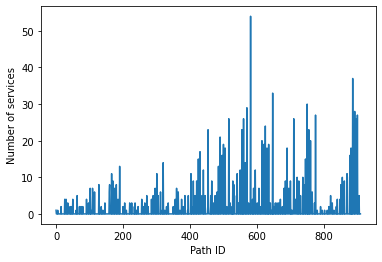

In [24]:
x = np.arange(num_paths)
plt.plot(x, path_id_util_1)
plt.xlabel("Path ID")
plt.ylabel("Number of services")
#plt.savefig('figures/pathid_services_kspff.pdf', dpi=200,bbox_inches='tight')
plt.show()

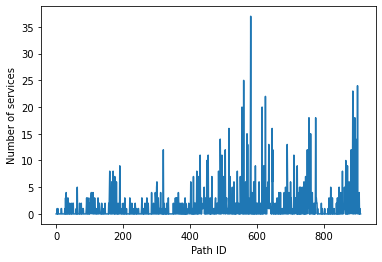

In [25]:
x = np.arange(num_paths)
plt.plot(x, path_id_util_2)
plt.xlabel("Path ID")
plt.ylabel("Number of services")
#plt.savefig('figures/pathid_services_ffksp.pdf', dpi=200,bbox_inches='tight')
plt.show()

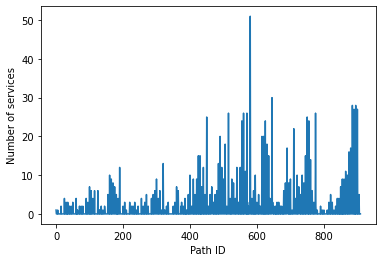

In [26]:
x = np.arange(num_paths)
plt.plot(x, path_id_util_3)
plt.xlabel("Path ID")
plt.ylabel("Number of services")
#plt.savefig('figures/pathid_services_ffksp.pdf', dpi=200,bbox_inches='tight')
plt.show()

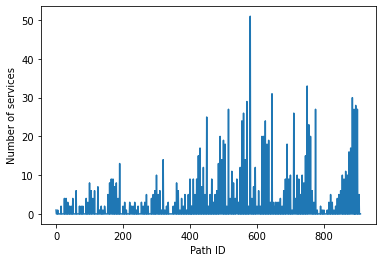

In [28]:
x = np.arange(num_paths)
plt.plot(x, path_id_util_4)
plt.xlabel("Path ID")
plt.ylabel("Number of services")
#plt.savefig('figures/pathid_services_ffksp.pdf', dpi=200,bbox_inches='tight')
plt.show()

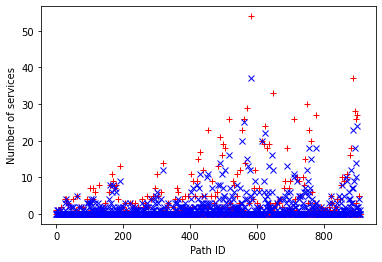

In [27]:
x = np.arange(num_paths)
plt.plot(x, path_id_util_1, 'r+')
plt.plot(x, path_id_util_2, 'bx')
plt.xlabel("Path ID")
plt.ylabel("Number of services")
plt.show()

In [ ]:
x = np.arange(num_paths)
plt.plot(x, abs(np.array(path_id_util_1) - np.array(path_id_util_2)))
plt.xlabel("Path ID")
plt.ylabel("Number of services")
#plt.savefig('figures/pathid_services_ffksp.pdf', dpi=200,bbox_inches='tight')
plt.show()

In [ ]:
(np.array(path_id_util_1) - np.array(path_id_util_2))

In [ ]:
np.array(path_id_util_1)

In [ ]:
np.array(path_id_util_2)

Look at ksp ordering:

In [ ]:
env_1.service.source

In [ ]:
paths_test = env_1.topology.graph['ksp']['2','3']
len(paths_test)

In [ ]:
paths_test[0].length

In [ ]:
paths_test[1].length

In [ ]:
paths_test[2].length

In [ ]:
paths_test[3].length

In [ ]:
paths_test[4].length